In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import shuffle
import random
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import TruncatedSVD
from numpy import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Converting the data to Sparse Matrix
rows = []
cols = []
data = []
with open('/content/drive/MyDrive/Colab/255/train.dat', 'r') as filereader:
    for num, record in enumerate(filereader):
        record = record.rstrip()
        wordList = record.split()
        cnt = int(len(wordList))
        for i in range(0,cnt,2):
            cols.append(int(wordList[i]))
            data.append(int(wordList[i+1]))
            rows.append(num)
matrix = csr_matrix((data,(rows, cols)), dtype = np.float)

In [ ]:
#Taking the TfidfTransformer for all the words and using tfidf instead of normal frequency.
tf_trans = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
tfid_matrix = tf_trans.fit_transform(matrix)

In [ ]:
#printing the matrix
tfid_matrix.shape

(8580, 126356)

In [ ]:
#dimensionality reduction to reduce the dimension of the data.
svd = TruncatedSVD(n_components=150)
data  = svd.fit_transform(tfid_matrix)

In [ ]:
print(data.shape)

(8580, 150)


In [ ]:
#initializeCentroids method set random values for centorid. Since we are using bisecting Kmean starting with 2 clusters so, 2 centroid.
def initializeCentroids(data):
    matrixShuffled = shuffle(data, random_state=42)
    return matrixShuffled[:2,:]

In [ ]:
#Checking for the matrix similarity with selected centroid column.
def similarity(data, centroids):
    similarities = data.dot(centroids.T)
    return similarities

In [ ]:
#Dividing the cluster into 2 clusters.
def bisecting_kmeans(data):
    cluster_1 = []
    cluster_2 = []   
   
    #Intializing centriod randomly
    centroids = initializeCentroids(data)

    #Checking for the similarity between the matrix and centriod.
    data_similarities = similarity(data, centroids)

    for index in range(data_similarities.shape[0]):
        #Check simlarity score of one row at a time.
        similarity_row = data_similarities[index]
        #Check which centriod is more similar and get that index.
        if(similarity_row[0] > similarity_row[1]):
          similarity_assign = 0
        else:
          similarity_assign = 1

        #Similarity_sorted index 0 means it is closer to 1st centriod else to the second centroid.
        if similarity_assign == 0:
            cluster_1.append(index)
        else:
            cluster_2.append(index)

    return cluster_1, cluster_2

In [ ]:
#Getting the index of the cluster that has high SSE Score.
def getIndexofMaxSSE(data, clusters):
    SSE_list = []
    SSE_array = []
    max_SSE = 0
    for cluster in clusters:
        points = data[cluster,:]
        SSE_points = np.sum(np.square(points - np.mean(points)))
        #Adding all SSE score to the list.
        SSE_list.append(SSE_points)

    # checking for SSE score from the list and returing the index of that cluster to the calling method.
    max_Index =0
    for i in range(len(SSE_list)):
      SSE = SSE_list[i]
      if SSE_list[i]>max_SSE:
          max_Index=i
          max_SSE=SSE

    return max_Index

In [ ]:
#Dividing the points into k Clusters.
def kmeans(data, k):
    
    clusterList= []
    initialClusterList = []

    #Initalizing inital cluster for all the rows.
    for i in range(data.shape[0]):
        initialClusterList.append(i) 
        
    clusterList.append(initialClusterList)

    #Iterate untill number of clusters is less than K
    while len(clusterList) < k:
        
        #Getting the index of the cluster that has max SSE.
        maxSSEInd = getIndexofMaxSSE(data, clusterList)
        #Getting the cluster with max SSE score.
        maxSSECluster = clusterList[maxSSEInd]
        
        #Passing the cluster to bisecting kemean method to get 2 clusters.
        cluster_1, cluster_2 = bisecting_kmeans(data[maxSSECluster,:])
       
        #Deleting the original cluster.
        del clusterList[maxSSEInd]
        
        #Adding the new clusters to the clusterlist.
        clusterList.append(cluster_1)
        clusterList.append(cluster_2)


    labels = [0] * data.shape[0]

    clusterList =  sorted(clusterList, key=lambda x: len(x), reverse=True)
    
    #Getting labels for each rows from individual cluster.
    for index, cluster in enumerate(clusterList):
      print("index", index, "size", len(cluster))
      for idx in cluster:
          labels[idx] = index + 1

    return labels

In [ ]:
#Calling the kmeasns
newClusterListlabels = kmeans(data, 7)

index 0 size 2134
index 1 size 2054
index 2 size 1022
index 3 size 943
index 4 size 915
index 5 size 796
index 6 size 716


In [ ]:
#Printing the output file
ItemID=[]
for i in range(1,data.shape[0]+1,1):
    ItemID.append(i);
with open('output_format.dat', 'w') as fw:
    print("{0}{1}{2}".format('DocumentID',',','ClusterID'),file=fw)
    for m in range(len(newClusterListlabels)):
        i = m+1
        print("{0}{1}{2}".format(i,',',newClusterListlabels[m]), file=fw)

In [ ]:
#Checking for silhouette evaluation Matrix
K_values = []
chsScore = []
labels = []
for k in range(3, 21, 2):
    labels=[]
    labels = kmeans(data,k)
    K_values.append(k)
    chsScore.append(calinski_harabasz_score(data, labels))

index 0 size 3808
index 1 size 3273
index 2 size 1499
index 0 size 2391
index 1 size 2026
index 2 size 1782
index 3 size 1499
index 4 size 882
index 0 size 2026
index 1 size 1782
index 2 size 1686
index 3 size 1499
index 4 size 882
index 5 size 425
index 6 size 280
index 0 size 1782
index 1 size 1499
index 2 size 1163
index 3 size 1158
index 4 size 882
index 5 size 863
index 6 size 528
index 7 size 425
index 8 size 280
index 0 size 1163
index 1 size 1158
index 2 size 1134
index 3 size 882
index 4 size 863
index 5 size 835
index 6 size 664
index 7 size 648
index 8 size 528
index 9 size 425
index 10 size 280
index 0 size 1163
index 1 size 883
index 2 size 882
index 3 size 863
index 4 size 835
index 5 size 685
index 6 size 664
index 7 size 648
index 8 size 528
index 9 size 449
index 10 size 425
index 11 size 280
index 12 size 275
index 0 size 883
index 1 size 882
index 2 size 863
index 3 size 835
index 4 size 710
index 5 size 685
index 6 size 664
index 7 size 648
index 8 size 528
index 9 

In [ ]:
# # Plotting silhoutte score
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.plot(K_values, sScore)
# plt.xlabel('Number of Clusters k')
# plt.ylabel('Silhouette Score')

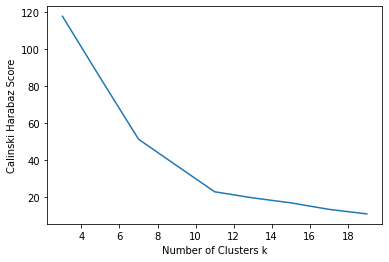

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(K_values, chsScore)
plt.xlabel('Number of Clusters k')
plt.ylabel('Calinski Harabaz Score')

plt.savefig('plot.png')
plt.show()